# Setup

### 1. Install required libraries

In [1]:
# BiocManager::install("philr")
# BiocManager::install("phyloseq")
# BiocManager::install("microbiome")
# install.packages("RColorBrewer")
# install.packages("UpSetR")
# install.packages("ggfortify")
# install.packages("randomForest")
# install.packages("rfUtilities")
# install.packages("phytools")
# install.packages("gridExtra")
# install.packages("remotes")
# install.packages('devtools')
# install.packages("intergraph")
# devtools::install_github('reptalex/phylofactor')
# devtools::install_github("briatte/ggnet")
# remotes::install_github("vmikk/metagMisc")
# remotes::install_github("pmartinezarbizu/pairwiseAdonis/pairwiseAdonis")
# remotes::install_github("gauravsk/ranacapa")

### 2. Load required libraries

In [2]:
library(philr)
library(RColorBrewer)
library(UpSetR)
library(ggfortify)
library(randomForest)
library(rfUtilities)
library(phytools)
library(phyloseq)
library(gridExtra)
library(microbiome)
library(phylofactor)
library(dplyr)
library(pairwiseAdonis)
library(ape)
library(metagMisc)
library(ranacapa)

Loading required package: ggplot2

randomForest 4.7-1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: ape

Loading required package: maps


Attaching package: ‘gridExtra’


The following object is masked from ‘package:randomForest’:

    combine



microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2021 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


Loading required package: magrittr

Loading required package: data.table

Loading required package: Matrix


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:gridExtra’:

    combine




### 3. Load data into R

In [3]:
map <- read.table("map.txt", sep="\t", header=T, row.names=1)
seqtab <- read.table("../01-read_processing/sequence_table.merged.txt", header=T, row.names=1)
tax <- read.table("../01-read_processing/taxonomy_bac.txt", header=F, row.names=1, sep="\t")
tree <- read.tree("../01-read_processing/rep_set.align.tre")
tree.root <- midpoint.root(tree)

### 4. Which samples are missing from metadata/sequence table?

In [4]:
notinmeta <- setdiff(row.names(seqtab), row.names(map))
notinraw <- setdiff(row.names(map), row.names(seqtab))
print("Samples not found in metadata:")
notinmeta
print("Samples not found in sequencing table:")
notinraw

[1] "Samples not found in metadata:"


[1] "DM00004V1PQ55"   "DM00004V1PQ65"   "DM00024V1PQ46-1" "DM00026V1PQ85-1"
 [5] "DM00148V1PQ75"   "DM00153V1PQ75"   "DM00165V1PQ75"   "DM00189V1PQ53"  
 [9] "DM00206V1PQ75"   "DM00217V1PQ65"   "DM00230V1PQ74"   "DM00237V1PQ75"  
[13] "DM00241V1PQ46"   "DM00241V1PQ74"   "DM00293V1PQ84"   "DM00380V1PQ36"  
[17] "DM00395V1PQ55"   "DM00543V1PQ75"   "DM00544V1PQ16"

[1] "Samples not found in sequencing table:"


character(0)

### 5. Create phyloseq object

In [5]:
ps.dat <- phyloseq(otu_table(seqtab, taxa_are_rows=F), sample_data(map), tax_table(as.matrix(tax)), tree.root)
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21801 taxa and 950 samples ]
sample_data() Sample Data:       [ 950 samples by 36 sample variables ]
tax_table()   Taxonomy Table:    [ 21801 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21801 tips and 21800 internal nodes ]

### 6. Filter out low prevalence ASVs

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


png 
  2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2971 taxa and 950 samples ]
sample_data() Sample Data:       [ 950 samples by 36 sample variables ]
tax_table()   Taxonomy Table:    [ 2971 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2971 tips and 2970 internal nodes ]

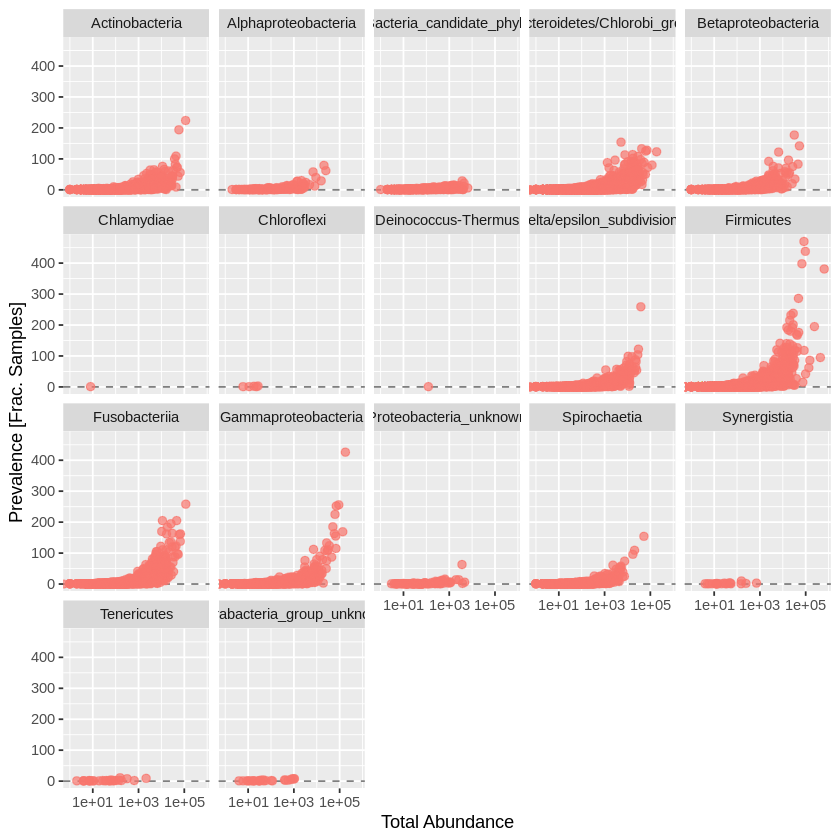

In [6]:
# compute prevalence dataframe
prevdf <- apply(X=otu_table(ps.dat), MARGIN=ifelse(taxa_are_rows(ps.dat), yes=1, no=2), FUN=function(x){sum(x>0)})
# add taxa and total read counts to dataframe
prevdf <- data.frame(Prevalence=prevdf, TotalAbundance=taxa_sums(ps.dat), tax_table(ps.dat))
# which phyla are comprised as mostly low prevalence ASVs?
lowprev <- ggplot(prevdf, aes(TotalAbundance, Prevalence, nsamples(ps.dat), color="V4")) + geom_hline(yintercept=0.05, alpha=0.5, linetype=2) + geom_point(size=2, alpha=0.7) + scale_x_log10() + xlab("Total Abundance") + ylab("Prevalence [Frac. Samples]") + facet_wrap(~V4) + theme(legend.position="none")
lowprev
pdf("totalabund_vs_prevalence.pdf")
lowprev
dev.off()
# kept asvs must be found in at least 1% of all samples 
ps.dat <- phyloseq_filter_prevalence(ps.dat, prev.trh=0.01)
ps.dat

### 7. Remove samples with fewer than 4000 reads post filtering, remove control samples

In [7]:
ps.dat <- prune_samples(sample_sums(ps.dat) > 4000, ps.dat)
ps.dat <- subset_samples(ps.dat, study_group != "mock")
ps.dat
# save image
save.image()

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2971 taxa and 784 samples ]
sample_data() Sample Data:       [ 784 samples by 36 sample variables ]
tax_table()   Taxonomy Table:    [ 2971 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2971 tips and 2970 internal nodes ]

### 8. Write filtered ASV, metadata, and taxonomy table to file

In [8]:
write.table(as.data.frame(otu_table(ps.dat)), "../01-read_processing/sequence_table.filt.txt", sep="\t", row.names=T, col.names=T)
# write filtered taxonomy to file
write.table(as.data.frame(tax_table(ps.dat)), "../01-read_processing/taxonomy_bac.filt.txt", sep="\t", row.names=T, col.names=T)
# filtered metadata
write.table(as.data.frame(sample_data(ps.dat)), "../01-read_processing/map.filt.txt", sep="\t", row.names=T, col.names=T)

# Rarefaction analysis

In [9]:
# rarecuv <- ggrare(ps.dat, step=10, label=NULL, color="", parallel=T)
# rarecuv
# pdf("img/rarecurve.pdf")
# rarecurv
# dev.off()

# Taxonomic analyses

### 1. Common phyla across samples (non-transformed data)

In [10]:
rel.abund <- transform_sample_counts(ps.dat, function(x) x/sum(x)) # get relative abundance
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[3]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V4 <- as.character(data$V4) # convert to character
data$V4[data$Abundance < 0.01] <- "< 1% abund" # rename low freq phyla
medians <- plyr::ddply(data, ~V4, function(x) c(median=median(x$Abundance)))
medians

V4,median
<chr>,<dbl>
< 1% abund,0.00000000
Actinobacteria,0.07052599
Alphaproteobacteria,0.02164343
Bacteria_candidate_phyla,0.01708118
Bacteroidetes/Chlorobi_group,0.23203463
Betaproteobacteria,0.04249870
delta/epsilon_subdivisions,0.04206023
Firmicutes,0.27616007
Fusobacteriia,0.13451477


### 2. Most common genera?

In [11]:
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[8]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V8 <- as.character(data$V8) # convert to character
data$V8[data$Abundance < 0.20] <- "< 20% abund" # rename low freq phyla
medians <- plyr::ddply(data, ~V8, function(x) c(median=median(x$Abundance)))
medians

V8,median
<chr>,<dbl>
< 20% abund,0.0000000
Abiotrophia,0.2330047
Aggregatibacter_aphrophilus,0.2162412
Alphaproteobacteria_unknown,0.2371833
Amphibacillus,0.2307771
"ant,_tsetse,_mealybug,_aphid,_etc._endosymbionts",0.2675973
Arachnia,0.3143569
Bacillales_Family_XI._Incertae_Sedis,0.2170074
Bacteroidales_unknown,0.4267426


### 3. Phylum level figures

png 
  2

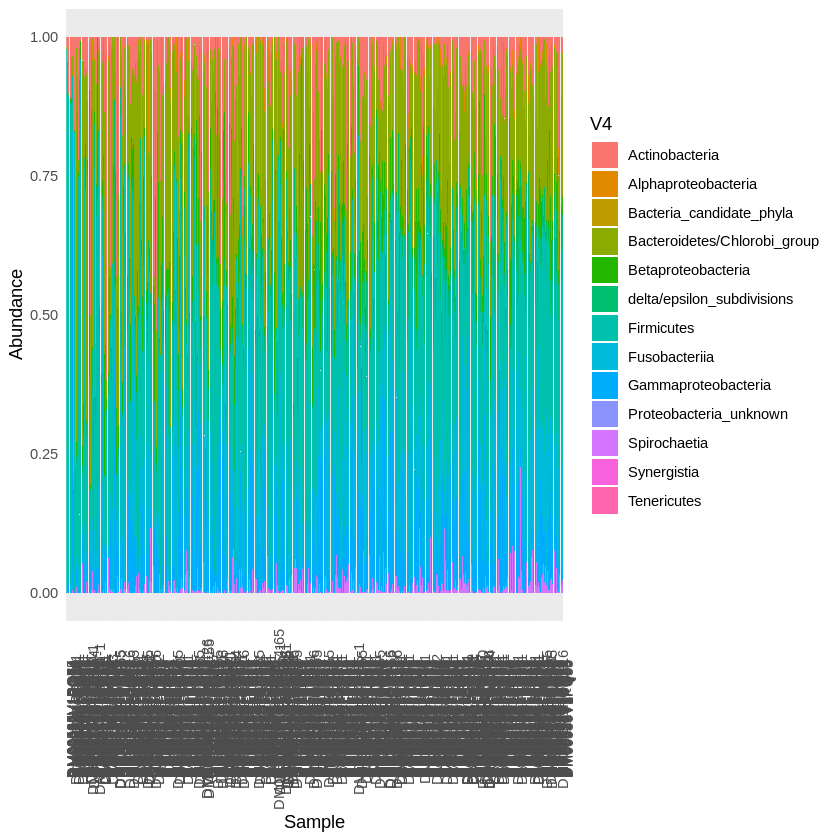

png 
  2

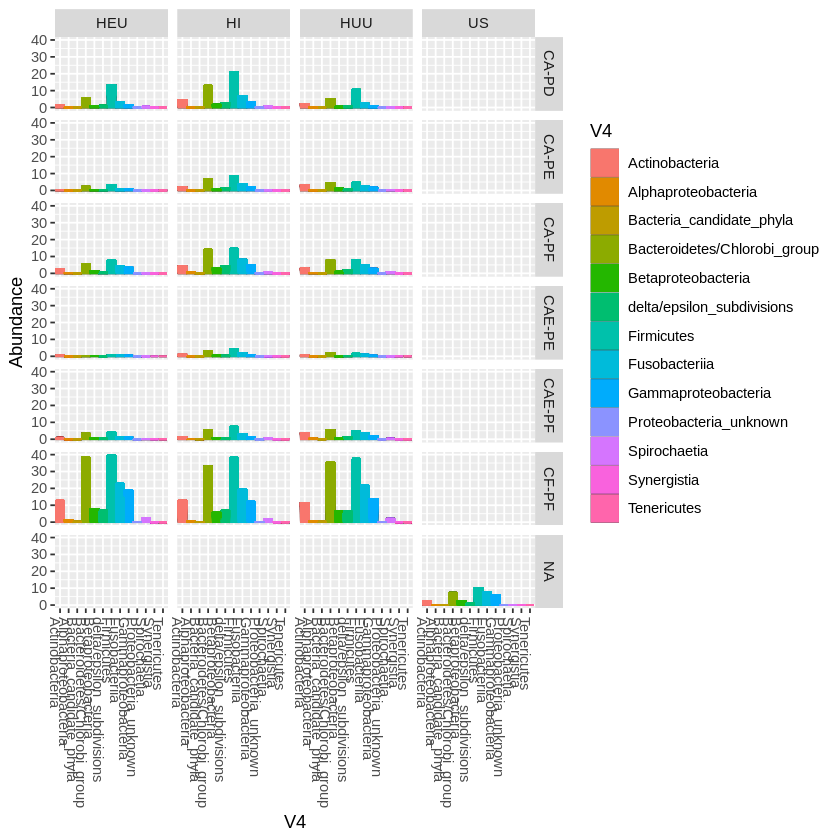

In [12]:
system("mkdir img")
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot by sample
taxbarsamp <- ggplot(data, aes(x=Sample, y=Abundance, fill=V4)) + geom_bar(aes(), stat="identity", position="stack") + theme_minimal() + theme(axis.text.x = element_text(angle = 90))
taxbarsamp
pdf("img/taxonomy_barchart.pdf")
taxbarsamp
dev.off()
# phyloseq group by hiv status and aliquot type
taxbargrp <- plot_bar(rel.abund, "V4", fill="V4", facet_grid=aliquot_type~study_group) + geom_bar(aes(color=V4, fill=V4), stat="identity", position="stack")
taxbargrp
pdf("img/tax_bar.aliquot_by_sample.pdf")
taxbargrp
dev.off()

### 4. Stacked barchart grouped by study group and aliquot type (phylum level)

`summarise()` has grouped output by 'study_group', 'aliquot_type'. You can override using the `.groups` argument.


png 
  2

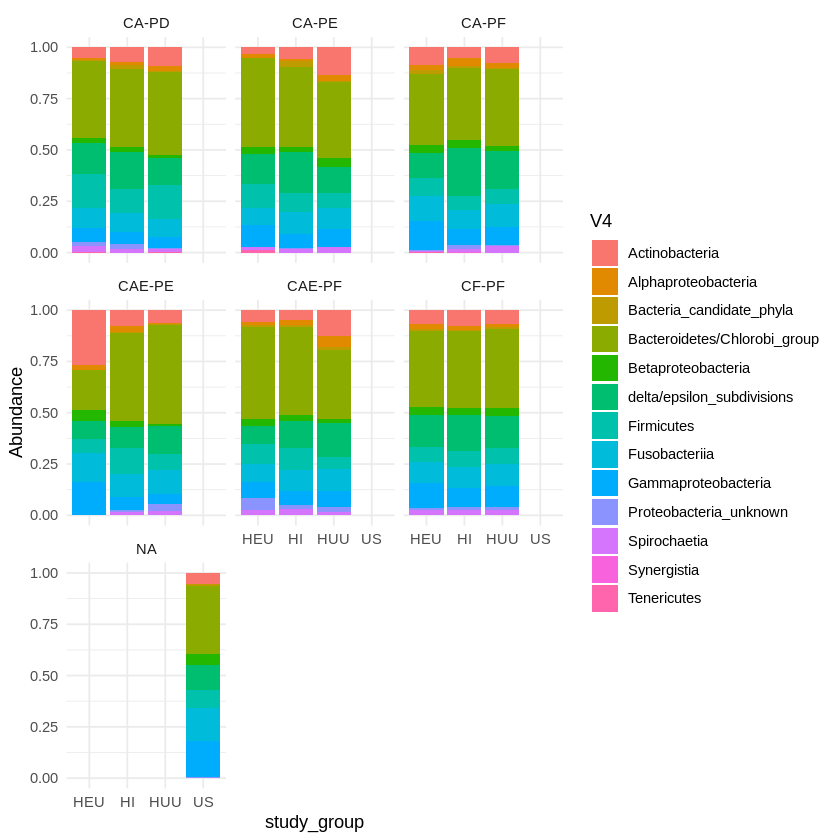

In [13]:
grouped <- data %>% group_by(study_group, aliquot_type, V4) %>% summarize(Abundance = mean(Abundance))
taxbarphy <- ggplot(grouped, aes(fill=V4, y=Abundance, x=study_group)) + geom_bar(position="fill", stat="identity") + facet_wrap(~aliquot_type) + theme_minimal()
taxbarphy
pdf("img/bar.study_group.phyla.pdf")
taxbarphy
dev.off()

### 5. Stacked barchart at family level (only above 20% frequency)

`summarise()` has grouped output by 'study_group', 'aliquot_type'. You can override using the `.groups` argument.


png 
  2

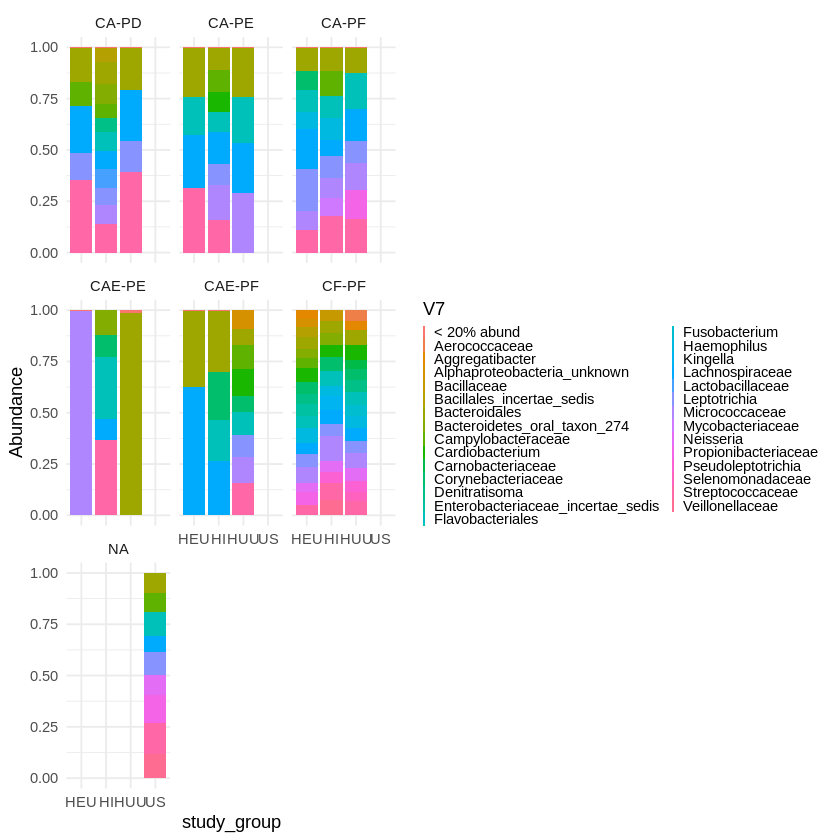

In [14]:
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[8]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V7 <- as.character(data$V7) # convert to character
data$V7[data$Abundance < 0.2] <- "< 20% abund" # rename low freq phyla
grouped <- data %>% group_by(study_group, aliquot_type, V7) %>% summarize(Abundance = mean(Abundance))
famtaxbar <- ggplot(grouped, aes(fill=V7, y=Abundance, x=study_group)) + geom_bar(position="fill", stat="identity") + facet_wrap(~aliquot_type) + theme_minimal() + theme(legend.key.size=unit(0.000001, "cm"))
famtaxbar
pdf("img/bar.study_group.L7.pdf")
famtaxbar
dev.off()

# PhILR transformation

In [15]:
philr.dat <- transform_sample_counts(ps.dat, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
is.rooted(phy_tree(philr.dat)) # check that tree is rooted
# [1] TRUE
is.binary(phy_tree(philr.dat)) #check that multichotomies are resolved in tree
# [1] TRUE
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")

[1] TRUE

[1] TRUE

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...



# Beta diversity

### 1. Get distance matrix from PhILR transformed data

In [16]:
philr.dist <- dist(philr.t, method="euclidean") 

### 2. PCA plots

$x
 [1]  0.7  1.9  3.1  4.3  5.5  6.7  7.9  9.1 10.3 11.5

$y
 [1] 481.112976  76.181747  21.645854  20.030481   5.136656   3.951431
 [7]   2.274170   1.677221   1.486232   1.383516

$xlab
NULL

$ylab
NULL

$x
 [1]  0.7  1.9  3.1  4.3  5.5  6.7  7.9  9.1 10.3 11.5

$y
 [1] 481.112976  76.181747  21.645854  20.030481   5.136656   3.951431
 [7]   2.274170   1.677221   1.486232   1.383516

$xlab
NULL

$ylab
NULL

png 
  2

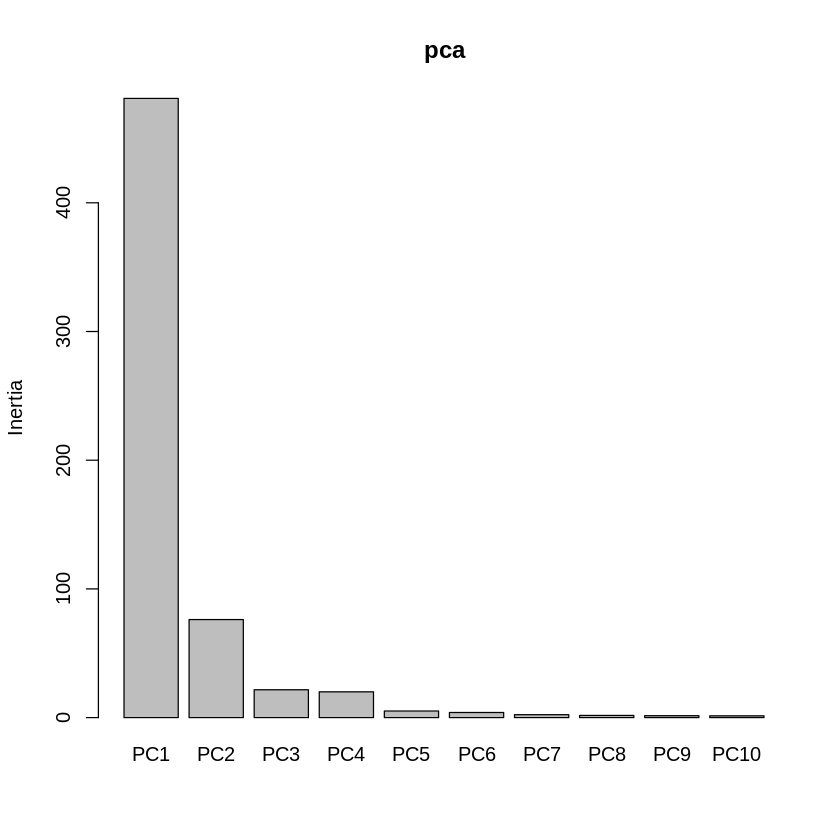

png 
  2

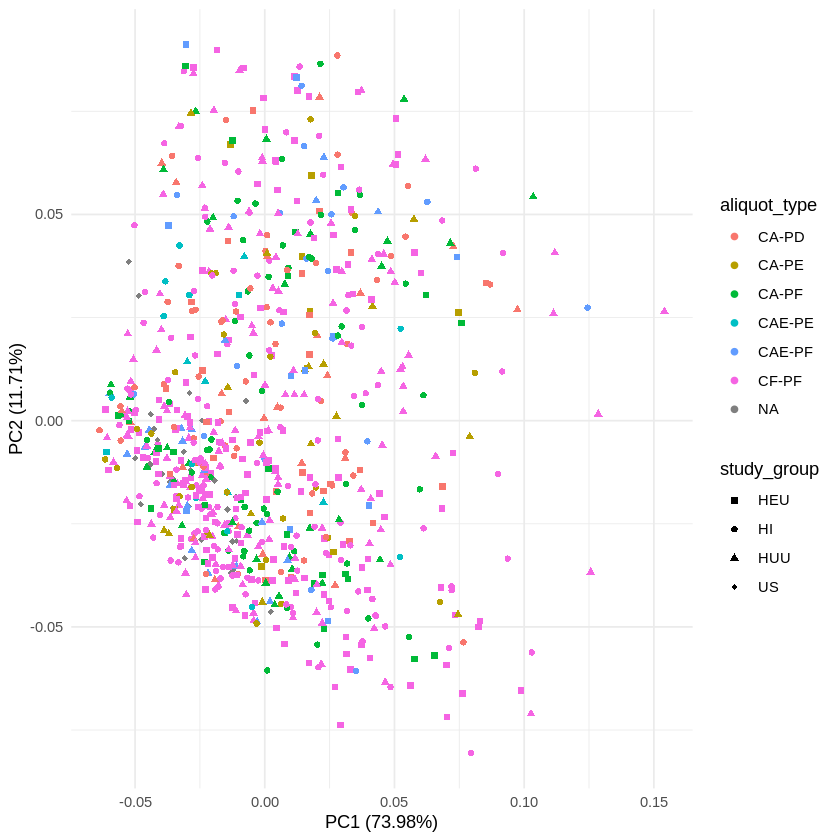

png 
  2

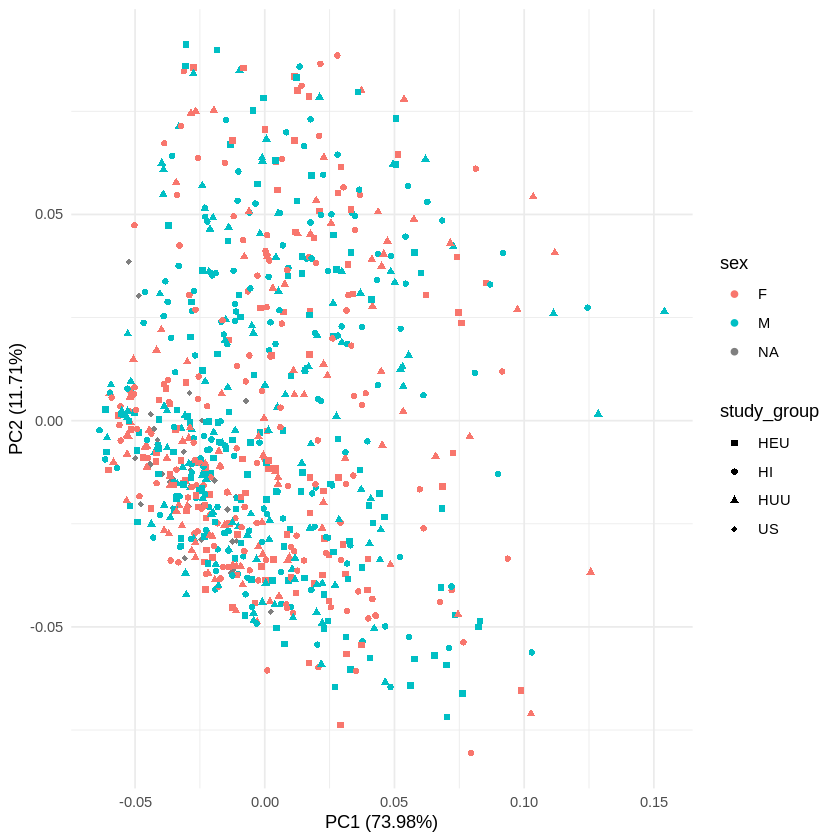

In [17]:
# scree plot
pca <- prcomp(as.matrix(philr.dist))
scree <- screeplot(pca)
scree
pdf("img/pca_screeplot.pdf")
scree
dev.off()
# colored by aliquot type, shape by study group
pca.plt <- autoplot(pca, data=sample_data(philr.dat), colour="aliquot_type", shape="study_group") + theme_minimal() + scale_shape_manual(values=c(15, 16, 17, 18))
pca.plt
pdf("img/pca.aliquot_type.pdf")
pca.plt
dev.off()
# study group, sex
pca.plt <- autoplot(pca, data=sample_data(philr.dat), colour="sex", shape="study_group") + theme_minimal() + scale_shape_manual(values=c(15, 16, 17, 18))
pca.plt
pdf("img/pca.sex.pdf")
pca.plt
dev.off()

### 3. PERMANOVA

Remove US kids from dataframe and regenerate philr dist `

In [20]:
philr.dat.noUS <- subset_samples(philr.dat, study_group != "US")
phy_tree(philr.dat.noUS) <- makeNodeLabel(phy_tree(philr.dat.noUS), method="number", prefix="n")
asv.table <- otu_table(philr.dat.noUS)
tree <- phy_tree(philr.dat.noUS)
metadata <- sample_data(philr.dat.noUS)
tax <- tax_table(philr.dat.noUS)
philr.t.noUS <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
# now generate distance matrix
philr.dist.noUS <- dist(philr.t.noUS, method="euclidean") 

                       DM00001V1PQ DM00005V1PQ46-2 DM00006V1PQ1 DM00007V1PQ1
DM00005V1PQ46-2           4.605422                                          
DM00006V1PQ1              5.528247        4.540319                          
DM00007V1PQ1              3.517190        3.336253     4.897005             
DM00008V1PQ16-2           6.007153        5.915287     6.742736     5.205710
DM00008V1PQ26-1           4.400061        4.752554     5.605362     3.800239
DM00009V1PQ65             4.455071        4.909912     5.642788     3.590792
DM00010V1PQ54             5.730248        6.217650     6.652738     5.120747
DM00011V1PQ55-1           4.883960        4.777175     5.507876     4.015463
DM00012V1PQ1              6.062908        5.854546     6.712749     5.238454
DM00013V1PQ65-3           5.327001        4.224636     5.179982     4.189276
DM00013V1PQ83-2           4.872498        4.432736     4.660424     4.214081
DM00014V1PQ3              4.989574        5.194772     6.213967     4.180215

In [22]:
metadata

,visit_num,study_id,aliquot_type,sex,age_y,study_group,antibiotics_syrup,beans,biscuits_cookies,bread,⋯,sugar_salt_soin_ors,sugary_liquids,sweets_chocolate,tea_chocolate_drink,tinned_powdered_milk,vegetables_fruits,yam_yam_pottage,breast_fed,infant_formula,colostrum
,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
DM00001V1PQ,1,DM00001,CAE-PE,M,9,HI,0,1,1,1,⋯,0,0,1,1,1,1,0,1,1,1
DM00005V1PQ46-2,1,DM00005,CF-PF,M,6,HUU,0,0,0,1,⋯,0,0,0,0,0,0,0,1,0,1
DM00006V1PQ1,1,DM00006,CF-PF,M,7,HI,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,1
DM00007V1PQ1,1,DM00007,CF-PF,M,6,HEU,0,0,0,0,⋯,0,0,0,1,1,0,0,1,0,1
DM00008V1PQ16-2,1,DM00008,CF-PF,F,9,HI,0,1,0,0,⋯,0,0,0,0,0,0,0,1,0,1
DM00008V1PQ26-1,1,DM00008,CF-PF,F,9,HI,0,1,0,0,⋯,0,0,0,0,0,0,0,1,0,1
DM00009V1PQ65,1,DM00009,CF-PF,F,3,HUU,0,1,1,1,⋯,0,1,0,1,0,1,0,1,1,1
DM00010V1PQ54,1,DM00010,CF-PF,M,5,HUU,0,1,1,1,⋯,0,0,0,1,1,1,0,1,1,1
DM00011V1PQ55-1,1,DM00011,CF-PF,F,8,HI,0,0,2,1,⋯,0,0,1,1,1,1,0,1,9,1


Comparing study group, aliquot type, sex, and age

In [26]:
# adonis(philr.dist.noUS ~ study_group * aliquot_type * sex * age_y, data=metadata)
adonis(philr.dist.noUS ~ study_group, data=(metadata))

ERROR: Error in eval(lhs, data, parent.frame()): invalid 'envir' argument of type 'character'


### 4. Pairwise tests

Matrix for neighbor joining trees

In [ ]:
t <- pairwise.adonis(otu_table(ps.dat.noUS), sample_data(ps.dat.noUS)$study_group)
# t
mat <- matrix(0, length(levels(as.factor(sample_data(ps.dat.noUS)$study_group))), length(levels(as.factor(sample_data(ps.dat.noUS)$study_group))))
mat[lower.tri(mat, diag=F)] <- t$F.Model
# mat
write.matrix(mat, "study_group_distance.formeta.meg", sep=" ")

t <- pairwise.adonis(otu_table(ps.dat.noUS), sample_data(ps.dat.noUS)$aliquot_type)
# t
mat <- matrix(0, length(levels(as.factor(sample_data(ps.dat.noUS)$aliquot_type))), length(levels(as.factor(sample_data(ps.dat.noUS)$aliquot_type))))
mat[lower.tri(mat, diag=F)] <- t$F.Model
# mat
write.matrix(mat, "aliquot_type_distance.formeta.meg", sep=" ")

# make new metadata category to do HIV status + tooth type
sample_data(ps.dat.noUS)$aliquot_study <- paste(sample_data(ps.dat.noUS)$study_group, sample_data(ps.dat.noUS)$aliquot_type, sep=".")
t <- pairwise.adonis(otu_table(ps.dat.noUS), sample_data(ps.dat.noUS)$aliquot_study)
# t
mat <- matrix(0, length(levels(as.factor(sample_data(ps.dat.noUS)$aliquot_study))), length(levels(as.factor(sample_data(ps.dat.noUS)$aliquot_study))))
mat[lower.tri(mat, diag=F)] <- t$F.Model
# mat
write.matrix(mat, "aliquot_type_study_group_distance.formeta.meg", sep=" ")

### 5. Beta dispersion tests

In [ ]:
dispr <- vegan::betadisper(philr.dist.noUS, phyloseq::sample_data(philr.dat.noUS)$aliquot_type)
print("aliquot type:")
dispr
permutest(dispr)
dispr <- vegan::betadisper(philr.dist.noUS, phyloseq::sample_data(philr.dat.noUS)$study_group)
print("study group:")
dispr
permutest(dispr)
dispr <- vegan::betadisper(philr.dist.noUS, phyloseq::sample_data(philr.dat.noUS)$sex)
print("sex:")
dispr
permutest(dispr)
dispr <- vegan::betadisper(philr.dist.noUS, phyloseq::sample_data(philr.dat.noUS)$age_y)
print("age:")
dispr
permutest(dispr)
betadis.age <- boxplot(dispr)
betadisp.age
pdf("img/betadispr.age.pdf")
betadisp.age
dev.off()
betadisp.ord <- plot(dispr)
betadisp.ord
pdf("img/betadispr.age.ord.pdf")
betadisp.ord
dev.off()

What if we looked at different tooth types by HIV status?

In [ ]:
phyloseq::sample_data(philr.dat.noUS)$study_aliquot <- with(phyloseq::sample_data(philr.dat.noUS), interaction(phyloseq::sample_data(philr.dat.noUS)$study_group, phyloseq::sample_data(philr.dat.noUS)$aliquot_type))
dispr <- vegan::betadisper(philr.dist.noUS, phyloseq::sample_data(philr.dat.noUS)$study_aliquot)
dispr
permutest(dispr)
df <- data.frame(group=dispr$group, distances=dispr$distances)
pdf("img/betadispr.study_aliquot.pdf")
ggplot(df, aes(group, distances)) + geom_boxplot() + theme(axis.text.x=element_text(angle=45))
dev.off()
ggplot(df, aes(group, distances)) + geom_boxplot() + theme(axis.text.x=element_text(angle=45))

Get phyloseq object with US kids removed

In [ ]:
ps.dat.noUS <- subset_samples(ps.dat, study_group != "US")

Distance based redundancy analysis

In [ ]:
ordcap <- ordinate(ps.dat, "CAP", "bray", ~study_group)
pdf("img/capscale_plt.study_group.pdf") 
plot_ordination(ps.dat, ordcap, "samples", color="study_group") + theme_minimal()
dev.off()
plot_ordination(ps.dat, ordcap, "samples", color="study_group") + theme_minimal()

ordcap <- ordinate(ps.dat.noUS, "CAP", "bray", ~aliquot_type)
pdf("img/capscale_plt.aliquot_type.pdf")
plot_ordination(ps.dat.noUS, ordcap, "samples", color="aliquot_type") + theme_minimal()
dev.off()
plot_ordination(ps.dat.noUS, ordcap, "samples", color="aliquot_type") + theme_minimal()

ordcap <- ordinate(ps.dat.noUS, "CAP", "bray", aliquot_type~study_group)
pdf("img/capscale_plt.aliquot_type.study_group.pdf")
plot_ordination(ps.dat, ordcap, "samples", color="aliquot_type", shape="study_group") + theme_minimal()
dev.off()
plot_ordination(ps.dat, ordcap, "samples", color="aliquot_type", shape="study_group") + theme_minimal()

# Alpha diversity

In [ ]:
# study group
pdf("img/adiv.study_group.pdf")
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="study_group") + geom_boxplot() + theme_minimal() 
dev.off()
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="study_group") + geom_boxplot() + theme_minimal() 

# sex
pdf("img/adiv.sex.pdf")
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="sex") + geom_boxplot() + theme_minimal()
dev.off()
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="sex") + geom_boxplot() + theme_minimal()

# age
sample_data(ps.dat.noUS)$age_y <- as.factor(sample_data(ps.dat.noUS)$age_y)
pdf("img/adiv.age_y.pdf")
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="age_y") + geom_boxplot() + theme_minimal()
dev.off()
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="age_y") + geom_boxplot() + theme_minimal()

# aliqout type 
pdf("img/adiv.aliqout_type.pdf")
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="aliquot_type") + geom_boxplot() + theme_minimal()
dev.off()
plot_richness(ps.dat.noUS, measures=c("Observed", "Shannon"),x="aliquot_type") + geom_boxplot() + theme_minimal()

# Shared features

In [ ]:
merged <- merge(otu_table(ps.dat), sample_data(ps.dat), by="row.names")
n <- ncol(otu_table(ps.dat)) + 1
# by sex
agg <- aggregate(merged[,2:n], by=list(merged$sex), FUN=sum) 
#remove columns with only zeros
agg <- agg[,colSums(agg !=0) > 0]
rownames(agg) <- agg$Group.1
#convert to presence absence table 
agg[agg>1] <- 1
agg <- data.frame(t(agg[,-1]))
pdf("img/upset.sex.pdf")
upset(agg, order.by="freq", mainbar.y.label="Number of ASVs", sets.x.label="Shared ASVs")
dev.off()

# by aliquot type
agg <- aggregate(merged[,2:n], by=list(merged$aliquot_type), FUN=sum) 
#remove columns with only zeros
agg <- agg[,colSums(agg !=0) > 0]
rownames(agg) <- agg$Group.1
#convert to presence absence table 
agg[agg>1] <- 1
agg <- data.frame(t(agg[,-1]))
#reorder
agg <- agg[,c("CA.PD", "CA.PE", "CA.PF", "CAE.PE", "CAE.PF", "CF.PF")]
pdf("img/upset.aliquot_type.pdf")
upset(agg, keep.order=T, sets=c("CA.PD", "CA.PE", "CA.PF", "CF.PF"), order.by="freq",mainbar.y.label="Number of ASVs", sets.x.label="Shared ASVs")
dev.off()

# by study_group
agg <- aggregate(merged[,2:n], by=list(merged$study_group), FUN=sum) 
#remove columns with only zeros
agg <- agg[,colSums(agg !=0) > 0]
rownames(agg) <- agg$Group.1
#convert to presence absence table 
agg[agg>1] <- 1
agg <- data.frame(t(agg[,-1]))
pdf("img/upset.study_group.pdf")
upset(agg, order.by="freq", mainbar.y.label="Number of ASVs", sets.x.label="Shared ASVs")
dev.off()
upset(agg, order.by="freq", mainbar.y.label="Number of ASVs", sets.x.label="Shared ASVs")

# Random forest classification

In [ ]:
# format data
asv_tab <- read.table("../02-read_processing/sequence_table.filt.txt", sep="\t", header=T, row.names=1, stringsAsFactors=F, comment.char="")
# remove us kids
asv_tab <- asv_tab[!grepl("L", row.names(asv_tab)),]
metadata <- read.table("../02-read_processing/map.filt.txt", sep="\t", header=T, row.names=1, stringsAsFactors=T, comment.char="")

metadata$study_group <- factor(metadata$study_group)
# get relative abudance
asv_tab_norm <- sweep(asv_tab, 2, colSums(asv_tab), '/')*100
asv_tab_scale <- scale(asv_tab_norm, center=T, scale=T)
asv_tab_var <- data.frame(asv_tab_scale)
# remove nas
asv_tab_var <- asv_tab_var[, colSums(is.na(asv_tab_var)) == 0]
set.seed(151)

# by study group
asv_tab_var$var <- metadata[rownames(asv_tab_var), "study_group"]
rf.study_group <- randomForest(x=asv_tab_var[,1:(ncol(asv_tab_var)-1)], y=asv_tab_var$var, ntree=10000, importance=T, proximity=T)
rf.study_group

# plot important ASVs
pdf("img/rf.study_group.importance.pdf")
varImpPlot(rf.study_group)
dev.off()
varImpPlot(rf.study_group)

# by aliquot type
# since there is a major sample number descrepancy, randomly sample to 100 samples in CA-PD, CA-PF, CF-PF (all others less than 100 samples) 
temp <- filter(asv_tab_var, var == "CF-PF" | var == "CA-PF" | var == "CA-PF" | var == "CA-PD")
temp$var <- droplevels(temp$var)
asv_tab_var.filt <- as.data.frame(temp %>% group_by(var) %>% sample_n(100))

rf.filt.aliquot_type <- randomForest(x=asv_tab_var.filt[,1:(ncol(asv_tab_var.filt)-1)], y=asv_tab_var.filt$var, ntree=10000, importance=T, proximity=T)
rf.filt.aliquot_type
# plot important ASVs
pdf("img/rf.filt.aliquot_type.importance.pdf")
varImpPlot(rf.filt.aliquot_type)
dev.off()
varImpPlot(rf.filt.aliquot_type)

# how do different tooth types look between HIV status states?
# first need to merge study_group and aliquot_type
metadata$study_aliquot <- with(metadata, interaction(study_group, aliquot_type))

# filtered to only include DOMHaIN samples, top tooth types
temp <- filter(asv_tab_var, var == "HEU.CF-PF" | var == "HI.CF-PF" | var == "HUU.CF-PF")
temp$var <- droplevels(temp$var)
asv_tab_var.filt <- as.data.frame(temp %>% group_by(var) %>% sample_n(100))

rf.filt.sample_aliquot <- randomForest(x=asv_tab_var.filt[,1:(ncol(asv_tab_var.filt)-1)], y=asv_tab_var.filt$var, ntree=10000, importance=T, proximity=T)
rf.filt.sample_aliquot
# CA-PD
temp <- filter(asv_tab_var, var == "HEU.CA-PD" | var == "HI.CA-PD" | var == "HUU.CA-PD")
temp$var <- as.factor(temp$var)
temp$var <- droplevels(temp$var)
asv_tab_var.filt <- as.data.frame(temp %>% group_by(var) %>% sample_n(20))
rf.filt.sample_aliquot <- randomForest(x=asv_tab_var.filt[,1:(ncol(asv_tab_var.filt)-1)], y=asv_tab_var.filt$var, ntree=10000, importance=T, proximity=T)
rf.filt.sample_aliquot

# Core taxa

In [ ]:
# normalize
ps.dat.core <- microbiome::transform(ps.dat, "compositional")
# overall top taxa
head(prevalence(ps.dat.core, detection = 1/100, sort = T), 10)
# core taxa in HI samples
head(prevalence(subset_samples(ps.dat.core, study_group == "HI"), detection = 1/100, sort = T), 10)
# core taxa in HEU samples
head(prevalence(subset_samples(ps.dat.core, study_group == "HEU"), detection = 1/100, sort = T), 10)
# core taxa in HUU samples
head(prevalence(subset_samples(ps.dat.core, study_group == "HUU"), detection = 1/100, sort = T), 10)
# what about differences in tooth type in HI individuals?
head(prevalence(subset_samples(ps.dat.core, study_group == "HI" & aliquot_type == "CF-PF"), detection = 1/100, sort = T), 10)
head(prevalence(subset_samples(ps.dat.core, study_group == "HI" & aliquot_type == "CA-PD"), detection = 1/100, sort = T), 10)
head(prevalence(subset_samples(ps.dat.core, study_group == "HUU" & aliquot_type == "CF-PF"), detection = 1/100, sort = T), 10)
head(prevalence(subset_samples(ps.dat.core, study_group == "HUU" & aliquot_type == "CA-PD"), detection = 1/100, sort = T), 10)
head(prevalence(subset_samples(ps.dat.core, study_group == "HEU" & aliquot_type == "CF-PF"), detection = 1/100, sort = T), 10)
head(prevalence(subset_samples(ps.dat.core, study_group == "HEU" & aliquot_type == "CA-PD"), detection = 1/100, sort = T), 10)